
# ASD Diagnosis with XGBoost

In [3]:
#Preprocessing Pipeline

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter  # ← add this import

# CONFIG
PHENOTYPE_FILE = "Phenotypic_V1_0b_preprocessed1.csv"  # Phenotypic CSV
ROIS_DIR       = "nyu_rois"                            # folder with *_rois_cc200.1D files
OUTPUT_X       = "cc200_fc_X_children.npy"
OUTPUT_Y       = "cc200_fc_y_children.npy"

#  LOAD PHENOTYPE DATA 
df = pd.read_csv(PHENOTYPE_FILE)
df = df[(df["AGE_AT_SCAN"] < 18) & df["DX_GROUP"].isin([1, 2])]
label_dict = dict(zip(df["FILE_ID"], df["DX_GROUP"] - 1))  # ASD=1, Control=0


TR_SEC        = 2.0               # Known TR for NYU (seconds)
VOXEL_SIZES   = (3.0, 3.0, 4.0)   # Known voxel dimensions (mm)


# Prepare lists for QC
subject_ids = []
sex_list    = []
FIQ_list    = []
num_vols    = []
scan_durs   = []
TR_list     = []
voxelX_list = []
voxelY_list = []
voxelZ_list = []

#  PROCESS FUNCTIONAL CONNECTIVITY ===
X = []
y = []
missing = []
subject_ids = []  # ensure this list exists

#  Make sure we collect subject IDs and sexes during processing ---
subject_ids = []
sex_list    = []

# (Inside your processing loop, when you append to X and y:)
for subj_id, label in tqdm(label_dict.items()):
    matches = [f for f in os.listdir(ROIS_DIR) if subj_id in f and f.endswith(".1D")]
    if not matches:
        missing.append(subj_id)
        continue

    file_path = os.path.join(ROIS_DIR, matches[0])
    try:
        data = np.loadtxt(file_path)       # (T,200)
        if data.shape[1] != 200:
            print(f"Skipped {subj_id}: unexpected shape {data.shape}")
            continue

        # connectivity features
        corr  = np.corrcoef(data.T)        # (200,200)
        upper = corr[np.triu_indices(200, k=1)]
        X.append(upper)
        y.append(label)

        # record subject-level QC info
        subject_ids.append(subj_id)

        # Sex (1=M,2=F in ABIDE)
        sex_code = int(df.loc[df["FILE_ID"] == subj_id, "SEX"].values[0])
        sex_list.append("M" if sex_code == 1 else "F")

        # Full-Scale IQ
        FIQ = float(df.loc[df["FILE_ID"] == subj_id, "FIQ"].values[0])
        FIQ_list.append(FIQ)

        # Number of volumes & scan duration
        nv = data.shape[0]
        num_vols.append(nv)
        scan_durs.append(TR_SEC * nv / 60.0)  # minutes

        # Constant TR & voxel sizes
        TR_list.append(TR_SEC)
        voxelX_list.append(VOXEL_SIZES[0])
        voxelY_list.append(VOXEL_SIZES[1])
        voxelZ_list.append(VOXEL_SIZES[2])

    except Exception as e:
        print(f"Error with {file_path}: {e}")
        missing.append(subj_id)

# CONVERT TO ARRAYS ===
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.uint8)

# BUILD QC DATAFRAME
qc_df = pd.DataFrame({
    "subject_id":   subject_ids,
    "label":        y,
    "sex":          sex_list,
    "FIQ":          FIQ_list,
    "TR_sec":       TR_list,
    "NumVols":      num_vols,
    "ScanDur_min":  scan_durs,
    "VoxelX_mm":    voxelX_list,
    "VoxelY_mm":    voxelY_list,
    "VoxelZ_mm":    voxelZ_list
})
qc_df["group"] = qc_df["label"].map({0: "Control", 1: "ASD"})

# PRINT COUNTS ===
print("\n=== Sample Counts by Group ===")
print(qc_df["group"].value_counts())

print("\n=== Sample Counts by Group & Sex ===")
print(pd.crosstab(qc_df["group"], qc_df["sex"]))

# SUMMARY STATS TABLE ===
summary = qc_df.groupby("group").agg({
    "FIQ":         ["mean", "std"],
    "TR_sec":      ["mean", "std"],
    "ScanDur_min": ["mean", "std"],
    "VoxelX_mm":   ["mean", "std"],
    "VoxelY_mm":   ["mean", "std"],
    "VoxelZ_mm":   ["mean", "std"]
})
print("\n=== Phenotypic & Acquisition Summary ===")
print(summary.to_markdown())



# SAVE OUTPUT ===
print("Final Data shape:", X.shape)
print("Labels shape:   ", y.shape)
print(f"Missing or failed: {len(missing)} subjects")

np.save(OUTPUT_X, X)
np.save(OUTPUT_Y, y)


100%|███████████████████████████████████████████████████████████████████████████████| 719/719 [00:01<00:00, 637.29it/s]


=== Sample Counts by Group ===
group
ASD        71
Control    57
Name: count, dtype: int64

=== Sample Counts by Group & Sex ===
sex       F   M
group          
ASD      19  52
Control   6  51

=== Phenotypic & Acquisition Summary ===
| group   |   ('FIQ', 'mean') |   ('FIQ', 'std') |   ('TR_sec', 'mean') |   ('TR_sec', 'std') |   ('ScanDur_min', 'mean') |   ('ScanDur_min', 'std') |   ('VoxelX_mm', 'mean') |   ('VoxelX_mm', 'std') |   ('VoxelY_mm', 'mean') |   ('VoxelY_mm', 'std') |   ('VoxelZ_mm', 'mean') |   ('VoxelZ_mm', 'std') |
|:--------|------------------:|-----------------:|---------------------:|--------------------:|--------------------------:|-------------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|
| ASD     |           112.38  |          14.5154 |                    2 |                   0 |                   5.86667 |                        0 |      

C:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [19903] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 1

🔁 Fold 2


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 3


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 4


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 5


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 6


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 7


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 8


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 9


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 10


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 11


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 12


C:\ProgramData\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 XGBoost Metrics (FC + Clinical + SelectKBest):
Precision: 0.7738
Recall:    0.9155
F1-score:  0.8387
Accuracy:  0.8047


C:\Users\odesd\AppData\Local\Temp\ipykernel_50656\845777734.py:132: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=metrics, showmeans=True)


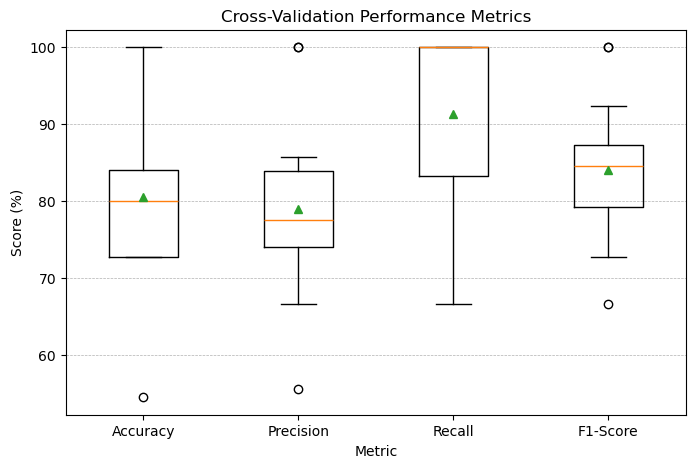

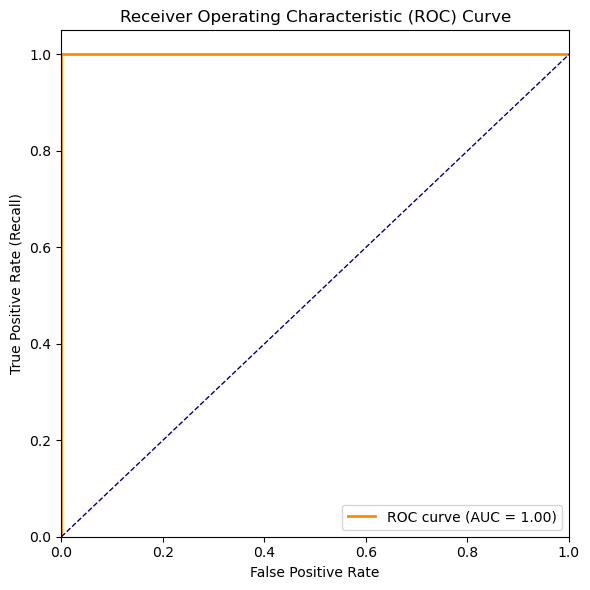

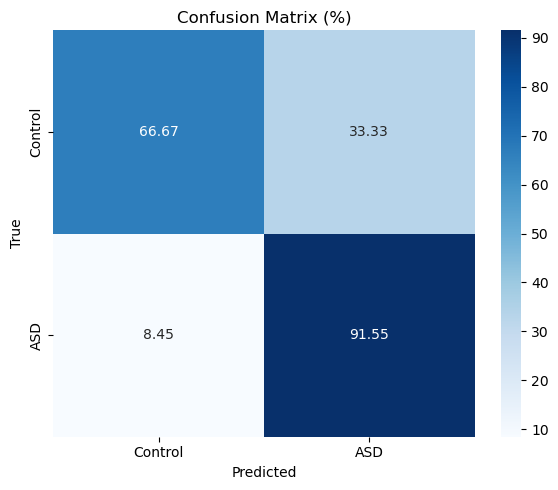

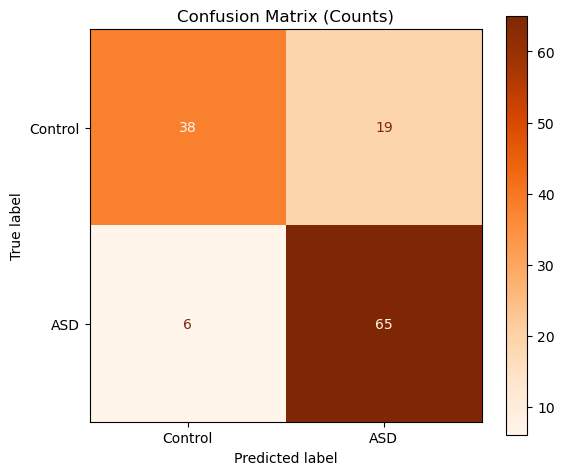

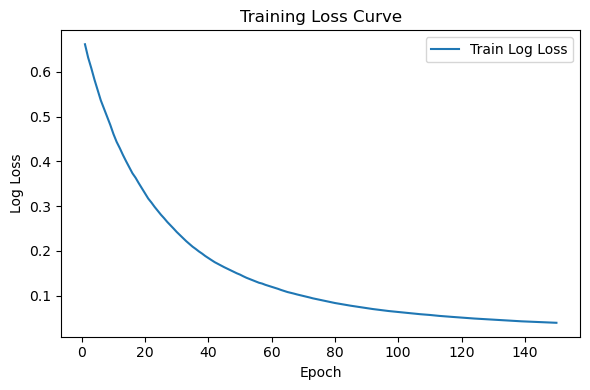

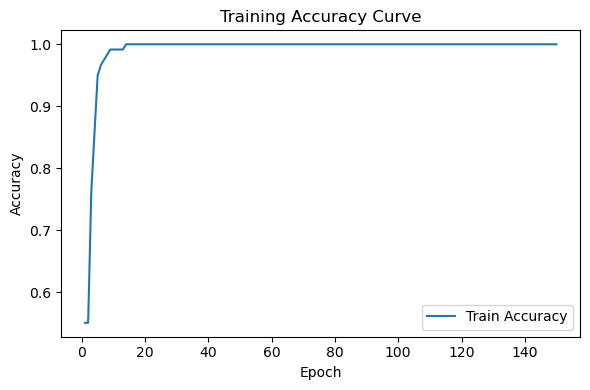

In [29]:
#Feature Engineering, XGBoost Model

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier, DMatrix, train as xgb_train


import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

import xgboost as xgb
from xgboost import XGBClassifier

# LOAD DATA
X_fc = np.load("cc200_fc_X_children.npy")
X_fc = np.nan_to_num(X_fc, nan=0.0)
y_labels = np.load("cc200_fc_y_children.npy")

pheno = pd.read_csv("Phenotypic_V1_0b_preprocessed1.csv")
# filter for children and relabel
pheno = pheno[(pheno["AGE_AT_SCAN"] < 18) & pheno["DX_GROUP"].isin([1, 2])].copy()
pheno["label"] = pheno["DX_GROUP"] - 1
pheno["SEX"]   = pheno["SEX"].map({1: 1, 2: 0})
pheno["FIQ"]   = pheno["FIQ"].fillna(pheno["FIQ"].mean())
pheno["AGE_AT_SCAN"] = pheno["AGE_AT_SCAN"].fillna(pheno["AGE_AT_SCAN"].mean())
pheno["SITE_ID"]      = LabelEncoder().fit_transform(pheno["SITE_ID"])

# match subjects
rois_files = os.listdir("nyu_rois")
subject_ids = [f.split("_rois")[0] for f in rois_files if f.endswith(".1D")]
pheno = pheno[pheno["FILE_ID"].isin(subject_ids)].reset_index(drop=True)

# demographic features
X_demo = pheno[["AGE_AT_SCAN","SEX","FIQ","SITE_ID"]].values
X_demo = StandardScaler().fit_transform(X_demo)

# combine features
X_combined = np.hstack([X_fc[:len(X_demo)], X_demo])
y_combined = pheno["label"].values

# univariate feature selection
selector = SelectKBest(score_func=f_classif, k=2000)
X_selected = selector.fit_transform(X_combined, y_combined)

# cross-validated training
skf = StratifiedKFold(n_splits=12, shuffle=True, random_state=30)
all_y_true, all_y_pred = [], []
conf_matrix_total = np.zeros((2,2), dtype=int)

# storage for per-fold metrics
cv_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for fold, (train_idx, test_idx) in enumerate(skf.split(X_selected, y_combined), 1):
    print(f"\n Fold {fold}")
    X_train, X_test = X_selected[train_idx], X_selected[test_idx]
    y_train, y_test = y_combined[train_idx], y_combined[test_idx]

    model = XGBClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric=["logloss","error"],
        random_state=42
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=False
    )
  
    y_scores = model.predict_proba(X_train)[:, 1]  # probability of class 1 (ASD)

    # collect predictions and confusion
    y_pred = model.predict(X_test)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    conf_matrix_total += confusion_matrix(y_test, y_pred)

    # after computing y_pred for this fold:
    cv_scores['accuracy'].append(accuracy_score(y_test, y_pred) * 100)
    cv_scores['precision'].append(precision_score(y_test, y_pred) * 100)
    cv_scores['recall'].append(recall_score(y_test, y_pred) * 100)
    cv_scores['f1'].append(f1_score(y_test, y_pred) * 100)


        # pull out the results dict
    results = model.evals_result()
    
        # define x_axis as the list of epoch indices
    num_epochs = len(results["validation_0"]["logloss"])
    x_axis = list(range(1, num_epochs + 1))


# compute metrics
precision = precision_score(all_y_true, all_y_pred)
recall    = recall_score(all_y_true, all_y_pred)
f1        = f1_score(all_y_true, all_y_pred)
accuracy  = accuracy_score(all_y_true, all_y_pred)

print("\n XGBoost Metrics (FC + Clinical + SelectKBest):")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

 #Boxplots of CV Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
data = [
    cv_scores['accuracy'],
    cv_scores['precision'],
    cv_scores['recall'],
    cv_scores['f1']
]

plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=metrics, showmeans=True)
plt.title('Cross-Validation Performance Metrics')
plt.ylabel('Score (%)')
plt.xlabel('Metric')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("cv_metrics_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()


#Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)


 #Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve_auc.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Percentage Confusion Matrix ---
conf_pct = conf_matrix_total / conf_matrix_total.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6,5))
sns.heatmap(
    conf_pct, annot=True, fmt=".2f", cmap="Blues",
    xticklabels=["Control","ASD"], yticklabels=["Control","ASD"]
)
plt.title("Confusion Matrix (%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_percent.png", dpi=300, bbox_inches="tight")
plt.show()


# --- ConfusionMatrixDisplay for raw counts ---
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix_total,
    display_labels=["Control","ASD"]
)
fig_cm, ax_cm = plt.subplots(figsize=(6,5))
disp.plot(ax=ax_cm, cmap="Oranges")
ax_cm.set_title("Confusion Matrix (Counts)")
fig_cm.tight_layout()
fig_cm.savefig("confusion_matrix_counts.png", dpi=300, bbox_inches="tight")
plt.show()


# --- Training Loss Curve ---
fig_loss, ax_loss = plt.subplots(figsize=(6,4))
ax_loss.plot(x_axis, results["validation_0"]["logloss"], label="Train Log Loss")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Log Loss")
ax_loss.set_title("Training Loss Curve")
ax_loss.legend()
fig_loss.tight_layout()
fig_loss.savefig("train_loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()


# --- Training Accuracy Curve ---
fig_acc, ax_acc = plt.subplots(figsize=(6,4))
ax_acc.plot(x_axis, [1 - e for e in results["validation_0"]["error"]], label="Train Accuracy")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.set_title("Training Accuracy Curve")
ax_acc.legend()
fig_acc.tight_layout()
fig_acc.savefig("train_accuracy_curve.png", dpi=300, bbox_inches="tight")
plt.show()

C:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [19903] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


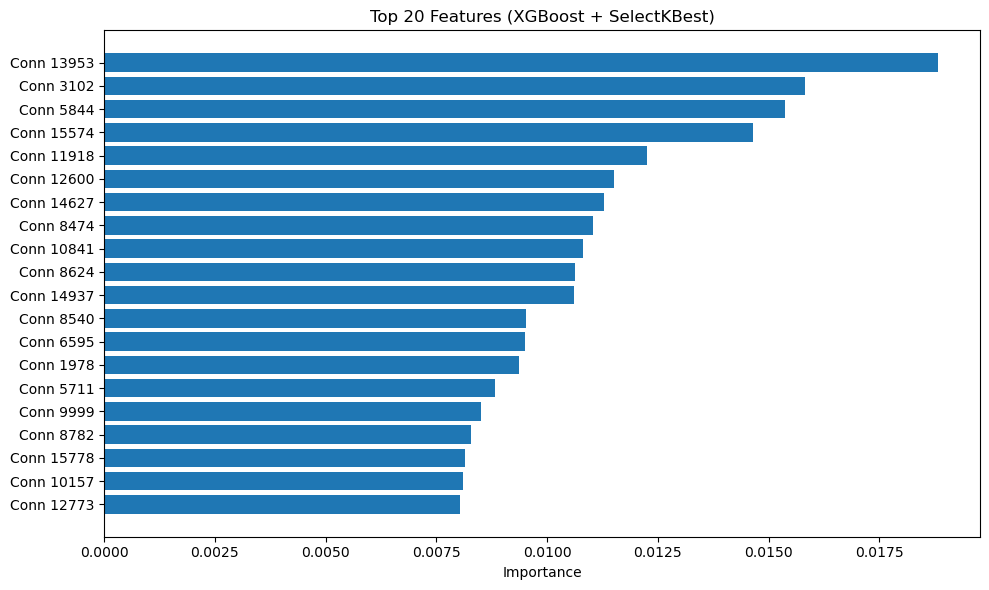


🧠 Top 20 Most Important Features:
 1. Conn 13953 | Importance: 0.0188
 2. Conn 3102  | Importance: 0.0158
 3. Conn 5844  | Importance: 0.0154
 4. Conn 15574 | Importance: 0.0146
 5. Conn 11918 | Importance: 0.0122
 6. Conn 12600 | Importance: 0.0115
 7. Conn 14627 | Importance: 0.0113
 8. Conn 8474  | Importance: 0.0110
 9. Conn 10841 | Importance: 0.0108
10. Conn 8624  | Importance: 0.0106
11. Conn 14937 | Importance: 0.0106
12. Conn 8540  | Importance: 0.0095
13. Conn 6595  | Importance: 0.0095
14. Conn 1978  | Importance: 0.0094
15. Conn 5711  | Importance: 0.0088
16. Conn 9999  | Importance: 0.0085
17. Conn 8782  | Importance: 0.0083
18. Conn 15778 | Importance: 0.0081
19. Conn 10157 | Importance: 0.0081
20. Conn 12773 | Importance: 0.0080


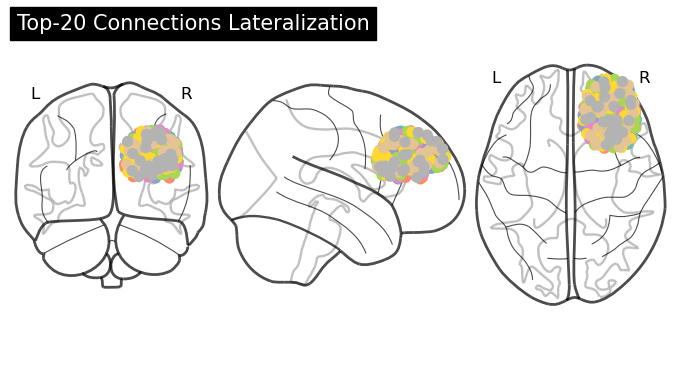

In [37]:
# Top 20 Most Important Features

import numpy as np
import pandas as pd
import os
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler

import nibabel as nib
from scipy.ndimage import center_of_mass
from nilearn.plotting import plot_connectome

# LOAD DATA 
X_fc = np.load("cc200_fc_X_children.npy")
X_fc = np.nan_to_num(X_fc, nan=0.0)
y = np.load("cc200_fc_y_children.npy")

pheno = pd.read_csv("Phenotypic_V1_0b_preprocessed1.csv")
pheno = pheno[(pheno["AGE_AT_SCAN"] < 18) & pheno["DX_GROUP"].isin([1, 2])].copy()
pheno["label"] = pheno["DX_GROUP"] - 1
pheno["SEX"]   = pheno["SEX"].map({1: 1, 2: 0})
pheno["FIQ"]   = pheno["FIQ"].fillna(pheno["FIQ"].mean())
pheno["AGE_AT_SCAN"] = pheno["AGE_AT_SCAN"].fillna(pheno["AGE_AT_SCAN"].mean())
pheno["SITE_ID"]      = LabelEncoder().fit_transform(pheno["SITE_ID"])

# Match and preprocess
subject_ids = [f.split("_rois")[0] for f in os.listdir("nyu_rois") if f.endswith(".1D")]
pheno = pheno[pheno["FILE_ID"].isin(subject_ids)].reset_index(drop=True)

X_demo = pheno[["AGE_AT_SCAN", "SEX", "FIQ", "SITE_ID"]].values
X_demo = StandardScaler().fit_transform(X_demo)

X_combined = np.hstack([X_fc[:len(X_demo)], X_demo])
y_combined = pheno["label"].values

#SelectKBest
selector = SelectKBest(score_func=f_classif, k=2500)
X_selected = selector.fit_transform(X_combined, y_combined)
mask = selector.get_support(indices=True)  # indices of selected features

# Train model
model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_selected, y_combined)

# Feature importances
importances = model.feature_importances_
top_indices = np.argsort(importances)[-20:][::-1]
top_values  = importances[top_indices]

# Map feature indices to name
feature_names = []
for idx in mask[top_indices]:
    if idx < 19900:
        feature_names.append(f"Conn {idx}")
    else:
        feature_names.append(["Age","Sex","FIQ","Site"][idx - 19900])

# Plot top 20 bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_values)), top_values[::-1])
plt.yticks(range(len(top_values)), feature_names[::-1])
plt.xlabel("Importance")
plt.title("Top 20 Features (XGBoost + SelectKBest)")
plt.tight_layout()
plt.savefig("Top_20_Features.png", dpi=300, bbox_inches="tight")
plt.show()

# TEXTUAL OUTPUT
print("\n Top 20 Most Important Features:")
for i, idx in enumerate(mask[top_indices]):
    if idx < 19900:
        name = f"Conn {idx}"
    else:
        name = ["Age","Sex","FIQ","Site"][idx - 19900]
    print(f"{i+1:2d}. {name:<10} | Importance: {top_values[i]:.4f}")

# Lateralization of Top 20 Connections

# Load CC200 atlas and extract centroids for each ROI label (1–200)
atlas_img  = nib.load("cc200_roi_atlas.nii.gz")
atlas_data = atlas_img.get_fdata()
roi_labels = np.unique(atlas_data)[1:].astype(int)  # skip 0 background

centroids = {}
for lbl in roi_labels:
    centroids[lbl] = center_of_mass(atlas_data == lbl)

# Build adjacency matrix for top-20 connections
n_rois  = 200
triu_i, triu_j = np.triu_indices(n_rois, k=1)
adj     = np.zeros((n_rois, n_rois))

for feat_idx, imp in zip(top_indices, top_values):
    i = triu_i[feat_idx]
    j = triu_j[feat_idx]
    adj[i, j] = imp
    adj[j, i] = imp

# Prepare list of coords in MNI space
# ROI labels in atlas are 1-based; our i,j indices are 0-based
coords = [centroids.get(l+1, (0,0,0)) for l in range(n_rois)]

# Plot connectome highlighting top connections
from nilearn.plotting import plot_connectome

plot_connectome(
    adjacency_matrix=adj,
    node_coords=coords,
    edge_kwargs={'linewidth': 2.0, 'alpha': 0.7},
    title="Top-20 Connections Lateralization",
    node_size=50
)
plt.savefig("Figure5_3_lateralization.png", dpi=300, bbox_inches="tight")
plt.show()

